In [1]:
 # %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2024-05-18T10:20:54.944095Z","iopub.execute_input":"2024-05-18T10:20:54.945260Z","iopub.status.idle":"2024-05-18T10:20:54.959222Z","shell.execute_reply.started":"2024-05-18T10:20:54.945195Z","shell.execute_reply":"2024-05-18T10:20:54.957600Z"}}
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hugging-face-vqa-small/data-00004-of-00136.arrow
/kaggle/input/hugging-face-vqa-small/data-00002-of-00136.arrow
/kaggle/input/hugging-face-vqa-small/data-00005-of-00136.arrow
/kaggle/input/hugging-face-vqa-small/data-00000-of-00136.arrow
/kaggle/input/hugging-face-vqa-small/data-00003-of-00136.arrow


In [2]:
import torch
from torch import nn
from transformers import AutoImageProcessor, AutoTokenizer, AutoModel, AutoConfig

2024-05-18 11:21:47.015927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 11:21:47.016041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 11:21:47.145657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
from datasets import load_dataset, load_from_disk, Dataset
dataset = load_dataset("/kaggle/input/hugging-face-vqa-small")

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_source, one_hot_encoder,transform=None):
        self.data_source = data_source
        self.one_hot_encoder = one_hot_encoder
        self.transform = transform
                
    def __len__(self):
        return len(self.data_source)

    def __getitem__(self, idx):
        item = self.data_source[idx]
#         print(type(item))
#         print(len(item))
#         print(item)
        image = item["image"]
        if self.transform:
            image = self.transform(image)
#         image.resize((224, 224))
        question = item["question"]
        label = item["multiple_choice_answer"]
        
        # Transform the label using the fitted one-hot encoder
        label_encoded = self.one_hot_encoder.transform(np.array(label).reshape(-1, 1))
        # Convert label_encoded to a PyTorch tensor
        label_tensor = torch.tensor(label_encoded, dtype=torch.float32)        
        return image, question, label_tensor

In [6]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False,max_categories=300)
one_hot_encoded_fit = one_hot_encoder.fit(np.array(dataset["train"]["multiple_choice_answer"]).reshape(-1, 1))
temp = one_hot_encoded_fit.transform(np.array(dataset["train"][3]["multiple_choice_answer"]).reshape(-1, 1))
# temp

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
from torchvision import transforms
from torchvision.transforms import v2

# transform = v2.Compose([
#     v2.Resize((224, 244), antialias=True),
# ])

transform = transforms.Compose([
#     transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_dataset = CustomDataset(dataset["train"],one_hot_encoded_fit,transform)

In [8]:
from transformers import BertConfig, BertModel, BertTokenizer

class VQAModel(nn.Module):
    def __init__(self, config, image_transformer="facebook/dinov2-base", text_transformer="google-bert/bert-base-uncased", output_size=300):
        super().__init__()
        
        # For image encoding
        self.image_processor = AutoImageProcessor.from_pretrained(image_transformer)
        self.image_model = AutoModel.from_pretrained(image_transformer).to(device)
        
        self.text_model_config = AutoConfig.from_pretrained("google-bert/bert-base-uncased", is_decoder=True,add_cross_attention=True)
        
        # For text encoding
        self.text_processor = AutoTokenizer.from_pretrained(text_transformer)
        self.text_model = AutoModel.from_config(self.text_model_config).to(device)
        
        # Freeze the parameters of the transformer models
        # As unable to train model with transformer weights
        for param in self.image_model.parameters():
            param.requires_grad = False
        for param in self.text_model.parameters():
            param.requires_grad = False

        # Concatenate the output of image and text and input to linear layer
        self.fc1 = nn.Linear(self.image_model.config.hidden_size+self.text_model.config.hidden_size, 2048)
        self.act_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(2048, 1024)
        self.act_fc2 = nn.ReLU()

        self.output_logits = nn.Linear(1024, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)

            
    def forward(self, image, text):
        # Image encoding 
        # pt for PyTorch tensor
        image_token = self.image_processor(image, return_tensors="pt").to(device)
        image_output = self.image_model(**image_token)
        last_hidden_states_image = image_output.last_hidden_state

        pooler_outputs_image = image_output.pooler_output
    
        # Text encoding
        text_token = self.text_processor(text, return_tensors="pt").to(device)
        text_output = self.text_model(**text_token, encoder_hidden_states=last_hidden_states_image)
        pooler_outputs_text = text_output.pooler_output
        
        input_to_linear = torch.cat((pooler_outputs_image, pooler_outputs_text), dim=1)
        
        x = self.act_fc1(self.fc1(input_to_linear))
        x = self.act_fc2(self.fc2(x))        
        x = self.logsoftmax(self.output_logits(x))
        
#         self.fc1 = nn.Linear(self.image_model.config.hidden_size+self.text_model.config.hidden_size, 2048)
#         self.act_fc1 = nn.ReLU()
        
#         self.fc2 = nn.Linear(2048, 1024)
#         self.act_fc2 = nn.ReLU()
        
        return x   
    
config = BertConfig(is_decoder="true")
model = VQAModel(config=config).to(device)
# from transformers import BertConfig, BertModel, BertTokenizer

# class VQAModel(nn.Module):
#     def __init__(self, config, image_transformer="facebook/dinov2-base", text_transformer="google-bert/bert-base-uncased", output_size=300):
#         super().__init__()
        
#         # For image encoding
#         self.image_processor = AutoImageProcessor.from_pretrained(image_transformer)
#         self.image_model = AutoModel.from_pretrained(image_transformer).to(device)
        
#         self.text_model_config = AutoConfig.from_pretrained("google-bert/bert-base-uncased", is_decoder=True,add_cross_attention=True)
        
#         # For text encoding
#         self.text_processor = AutoTokenizer.from_pretrained(text_transformer)
#         self.text_model = AutoModel.from_config(self.text_model_config).to(device)
        
#         # Freeze the parameters of the transformer models
#         # As unable to train model with transformer weights
#         for param in self.image_model.parameters():
#             param.requires_grad = False
#         for param in self.text_model.parameters():
#             param.requires_grad = False

#         # Concatenate the output of image and text and input to linear layer
#         self.fc1 = nn.Linear(self.text_model.config.hidden_size, 2048)
#         self.act_fc1 = nn.ReLU()
        
#         self.fc2 = nn.Linear(2048, 1024)
#         self.act_fc2 = nn.ReLU()

#         self.output_logits = nn.Linear(1024, output_size)
#         self.logsoftmax = nn.LogSoftmax(dim=1)

            
#     def forward(self, image, text):
#         # Image encoding 
#         # pt for PyTorch tensor
#         image_token = self.image_processor(image, return_tensors="pt").to(device)
#         image_output = self.image_model(**image_token)
#         last_hidden_states_image = image_output.last_hidden_state
    
#         # Text encoding
#         text_token = self.text_processor(text, return_tensors="pt").to(device)
#         text_output = self.text_model(**text_token, encoder_hidden_states=last_hidden_states_image)
#         pooler_outputs_text = text_output.pooler_output
        
#         #input_to_linear = torch.cat((last_hidden_states_image, pooler_outputs_text), dim=1)
        
#         x = self.act_fc1(self.fc1(pooler_outputs_text))
#         x = self.act_fc2(self.fc2(x))        
#         x = self.logsoftmax(self.output_logits(x))
        
# #         self.fc1 = nn.Linear(self.image_model.config.hidden_size+self.text_model.config.hidden_size, 2048)
# #         self.act_fc1 = nn.ReLU()
        
# #         self.fc2 = nn.Linear(2048, 1024)
# #         self.act_fc2 = nn.ReLU()
        
#         return x   
    
# config = BertConfig(is_decoder="true")
# model = VQAModel(config=config).to(device)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import torch.optim as optim
from datetime import datetime
def Train(model, train_dataset, n_epochs=2, loss_fn=nn.CrossEntropyLoss(), optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)):
    epoch_loss = []
    epoch_no = []
    no_image_seen = []
    loss_batch = []
    epoch_batch = []
    accuracies = []
    
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for i in range(len(train_dataset)):
            images, questions, labels = train_dataset[i]
            labels = labels.to(device)
            
            if images.shape[0] != 1:
                # Forward pass
                outputs = model(images, questions)
                loss = loss_fn(outputs, labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                no_image_seen.append(i)
                loss_batch.append(loss.item())
                epoch_batch.append(epoch)
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

                # Print loss for every 200 inputs
                if i % 200 == 0:
                    print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_dataset)}], Loss: {loss.item():.4f}")

        epoch_loss.append(running_loss)
        epoch_no.append(epoch)

        # Calculate accuracy for the epoch
        epoch_accuracy = total_correct / total_samples
        accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Plot loss graph
    plt.plot(epoch_no, epoch_loss, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

    print('Training complete')
    
    return epoch_loss, epoch_no, no_image_seen, loss_batch, epoch_batch, accuracies

# from torch.utils.data import DataLoader
# import torch.optim as optim
# from datetime import datetime

# # Hyperparameters
# batch_size = 16
# num_epochs = 5
# learning_rate = 1e-2

# # Create DataLoader for the training dataset
# # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)





# def Train(model,train_dataset,n_epochs=5,loss_fn=nn.CrossEntropyLoss(),optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)):
#     epoch_loss = []
#     epoch_no=[]
#     no_image_seen=[]
#     loss_batch = []
#     epoch_batch = []
#     # Training loop
#     # for epoch in range(num_epochs):
#     for epoch in range(n_epochs):
#         model.train()
#         running_loss = 0.0
#         loss_add=0.0
#         print(f"epochs  {epoch}")
#         start_epoch = datetime.now()
#         for i in range(0,len(train_dataset)):
#             images, questions, labels = train_dataset[i]
#             labels = labels.to(device)
#             # ignore single channel image
#             if(images.shape[0]!=1):
#                 # Forward pass
#                 outputs = model(images, questions)
#                 loss = criterion(outputs, labels)
#                 loss_add+=loss
#                 #back propogate for every 100 inputs loss 
#                 if(i%200==0):
#                     loss_add=loss_add/200 # average loss
#                     print(f"epoch= {epoch}, i= {i} loss_add= {loss_add}")        
#                     # Backward pass and optimization
#                     optimizer.zero_grad()
#                     loss_add.backward()
#                     optimizer.step()
#                     running_loss+=loss_add
#                     no_image_seen.append(i)
#                     loss_batch.append(loss_add)
#                     epoch_batch.append(epoch)
#                     loss_add=0
                    
                    
#         epoch_loss.append(running_loss)
#         epoch_no.append(epoch)
#         end_epoch = datetime.now()
#         td = (end_epoch - start_epoch).total_seconds()
#         print(f"The time of execution of epoch {epoch} : {td:.03f}s")
            
#     print('Training complete')
    
#     return epoch_loss ,epoch_no,no_image_seen,loss_batch,epoch_batch

In [10]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )
    
print_trainable_parameters(model)

trainable params: 5553452 || all params: 229983020 || trainable%: 2.41


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch [1/5], Step [1/16315], Loss: 5.6621
Epoch [1/5], Step [201/16315], Loss: 3.0687
Epoch [1/5], Step [401/16315], Loss: 5.6569
Epoch [1/5], Step [601/16315], Loss: 1.6440
Epoch [1/5], Step [801/16315], Loss: 1.7652
Epoch [1/5], Step [1001/16315], Loss: 6.9737
Epoch [1/5], Step [1201/16315], Loss: 2.9783
Epoch [1/5], Step [1401/16315], Loss: 6.1238
Epoch [1/5], Step [1601/16315], Loss: 1.7086
Epoch [1/5], Step [1801/16315], Loss: 3.6010
Epoch [1/5], Step [2001/16315], Loss: 3.0113
Epoch [1/5], Step [2201/16315], Loss: 1.6263
Epoch [1/5], Step [2401/16315], Loss: 3.9640
Epoch [1/5], Step [2601/16315], Loss: 1.7988
Epoch [1/5], Step [2801/16315], Loss: 2.8821
Epoch [1/5], Step [3001/16315], Loss: 3.5143
Epoch [1/5], Step [3201/16315], Loss: 1.2019
Epoch [1/5], Step [3401/16315], Loss: 6.1226
Epoch [1/5], Step [3601/16315], Loss: 1.2078
Epoch [1/5], Step [3801/16315], Loss: 2.7741
Epoch [1/5], Step [4001/16315], Loss: 7.3219
Epoch [1/5], Step [4201/16315], Loss: 6.1162
Epoch [1/5], Step

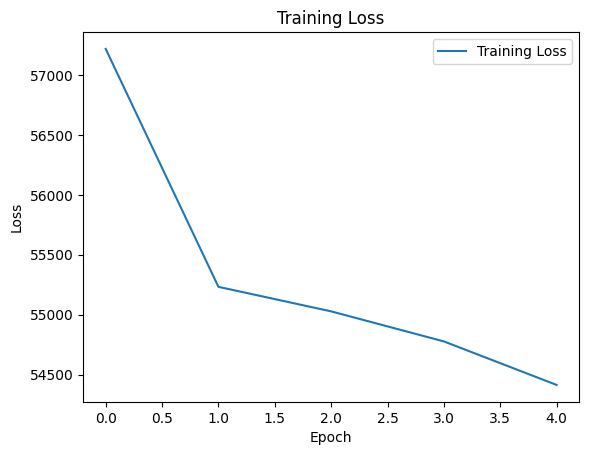

Training complete


ValueError: too many values to unpack (expected 5)

In [11]:
n_epochs=5
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

start = datetime.now()
epoch_loss ,epoch_no,no_image_seen,loss_batch,epoch_batch = Train(model,train_dataset,n_epochs,loss_fn,optimizer)
end = datetime.now()

In [ ]:
torch.save(model.state_dict(), 'd_b_concat.pth')